In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Martian Frost HiRISE Image Classification
* Data confidence weighting
* Predicts frost_context probabilities

Outside of built-in python 3 libraries, this code uses numpy, skimage, tqdm, PIL, matplotlib, and tensorflow.

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Suggested Data Split

Use the suggested train/val/test split to avoid data leakage across each data subset from a geospatial perspective.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./splits/train_source_images.txt')
validate_ids = load_text_ids('./splits/val_source_images.txt')
test_ids = load_text_ids('./splits/test_source_images.txt')

## Prepare data as numpy arrays

Load the data and pair a tile with its label. Each tile is stored in a numpy array under its parent. Each tile is a data object containing the following parameters:
* `tile`: the png image data
* `label`: the entire json for the tile
* `class`: the class of the tile
* `file`: the filename of the tile
* `data`: the json annotations
* `defrosting`: whether the image contains defrosting marks

In [4]:
from skimage import io, color
# modified this function to pair a tile with its label

limit_tiles_per_img = True
tile_limit = 100

# define the cutoff hyperparameter
cutoff = 0.5

def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {'file': dir_path.stem, 'class': '', 'tiles': []}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                contains_defrosting = 0

                if images['class'] == '':
                    images['class'] = image_class
                
                # Load the image, save it to our list
                img = io.imread(fp)

                if len(img.shape) == 2:  # check if the image is grayscale
                    img = color.gray2rgb(img)  # convert to RGB

                # locate the associated label json
                label_fp = op.join(dir_path, 'labels', image_class, f'{file.stem}.json')
                with open(label_fp, 'r') as f:
                    label_json = json.load(f)
                
                for annotation in label_json["annotations"]:
                    for context in annotation['frost_context']:
                        if context == "defrosting_marks":
                            contains_defrosting = 1

                combined_entry = {"tile": img,
                                  "data": label_json, 
                                  "class": image_class,
                                  "defrosting": contains_defrosting,
                                  "file": file.stem}
                
                images['tiles'].append(combined_entry)
    if limit_tiles_per_img:
        img_tiles = images['tiles']
        lim = min(tile_limit, len(img_tiles))
        tiles_lim = np.random.choice(img_tiles, lim, replace=False)
        images['tiles'] = tiles_lim
    return images

## Split the data into train/val/test
Make use of load_images above and bin the data properly. It will bin according to the txt files imported above.

In [5]:
train_data = []
validate_data = []
test_data = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir in tqdm(subdirs, desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    for i in range(len(train_ids)):
        if train_ids[i] in str(full_path):
            train_data.append(load_images(full_path))
    for j in range(len(validate_ids)):
        if validate_ids[j] in str(full_path):
            validate_data.append(load_images(full_path))
    for k in range(len(test_ids)):
        if test_ids[k] in str(full_path):
            test_data.append(load_images(full_path))

10:12:07 | INFO  | 2031110659      | Loading ML data from 214 subframes.
Creating Dataset as Numpy array: 100%|██████████| 214/214 [02:02<00:00,  1.75it/s]


## Check the size of each bin
Just to check and make sure we binned correctly!

In [6]:
if (len(train_data) + len(validate_data) + len(test_data)) != 214:
    print("Error: Data not loaded and/or binned correctly")
else:
    print("Good to go!")
    # print all lengths, and the amount with frost/background class
    print(f"    -> Train size: {len(train_data)}")
    print(f"    -> Validate size: {len(validate_data)}")
    print(
        f"    -> Test size: {len(test_data)}")


Good to go!
    -> Train size: 102
    -> Validate size: 55
    -> Test size: 57


## Print a random tile and its class
Print a random tile and its data to make sure everything is working properly.

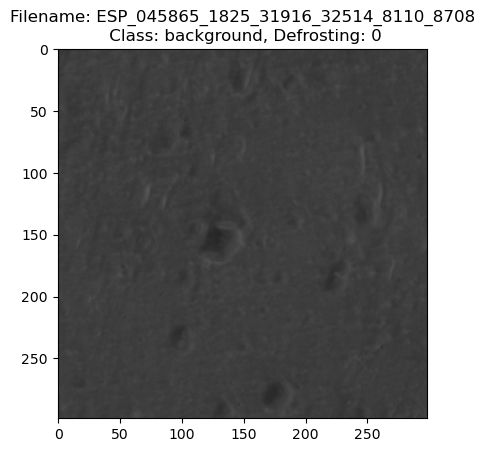

In [7]:
import matplotlib.pyplot as plt
import random

def display_random_image_and_json(some_data):
    # Pick a random image that has frost
    idx = random.choice(range(len(some_data)))
    tile_i = random.choice(range(len(some_data[idx]['tiles'])))
    img_dict = some_data[idx]['tiles'][tile_i]

    img = img_dict['tile']

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Set the title
    ax.set_title(
        f"Filename: {img_dict['file']}\n Class: {img_dict['class']}, Defrosting: {img_dict['defrosting']}")

    plt.show()


display_random_image_and_json(train_data)


## Preprocess data

Gather and bin the data

In [8]:
only_defrosting = False

# Train Data
X_train = []
y_train = []
for i in range(len(train_data)):
    for j in range(len(train_data[i]['tiles'])):
        X_train.append(train_data[i]['tiles'][j]['tile'])
        if only_defrosting:
            y_train.append(train_data[i]['tiles'][j]['defrosting'])
        else:
            y_train.append(int(train_data[i]['tiles'][j]['class'] == "frost"))

# Validate Data
X_val = []
y_val = []
for i in range(len(validate_data)):
    for j in range(len(validate_data[i]['tiles'])):
        X_val.append(validate_data[i]['tiles'][j]['tile'])
        if only_defrosting:
            y_val.append(validate_data[i]['tiles'][j]['defrosting'])
        else:
            y_val.append(int(validate_data[i]['tiles'][j]['class'] == "frost"))

# Test Data
X_test = []
y_test = []
for i in range(len(test_data)):
    for j in range(len(test_data[i]['tiles'])):
        X_test.append(test_data[i]['tiles'][j]['tile'])
        if only_defrosting:
            y_test.append(test_data[i]['tiles'][j]['defrosting'])
        else:
            y_test.append(int(test_data[i]['tiles'][j]['class'] == "frost"))

Format the data

In [9]:
# Convert lists to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [10]:
frost_count = 0
for item in y_train:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_train))}%) are frost out of {len(y_train)} in the training set")

3358 (51.909104962127074%) are frost out of 6469 in the training set


In [11]:
frost_count = 0
for item in y_val:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_val))}%) are frost out of {len(y_val)} in the validation set")

import numpy as np

# get the indices of 0's and 1's
indices_0 = np.where(y_val == 0)[0]
indices_1 = np.where(y_val == 1)[0]

# number of 0's and 1's
num_0 = len(indices_0)
num_1 = len(indices_1)

# choose random indices of 0's equal to the size of 1's
random_indices_0 = np.random.choice(indices_0, num_1, replace=False)

# combine the random indices of 0's with indices of 1's
combined_indices = np.concatenate((random_indices_0, indices_1))

# select the balanced data
X_val_balanced = X_val[combined_indices]
y_val_balanced = y_val[combined_indices]

frost_count = 0
for item in y_val_balanced:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_val_balanced))}%) are frost out of {len(y_val_balanced)} in the validation set")


1192 (27.516158818097875%) are frost out of 4332 in the validation set
1192 (50.0%) are frost out of 2384 in the validation set


In [12]:
frost_count = 0
for item in y_test:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test))}%) are frost out of {len(y_test)} in the test set")

# get the indices of 0's and 1's
t_indices_0 = np.where(y_test == 0)[0]
t_indices_1 = np.where(y_test == 1)[0]

print(t_indices_0)

# number of 0's and 1's
t_num_0 = len(t_indices_0)
t_num_1 = len(t_indices_1)

# choose random indices of 0's equal to the size of 1's
t_random_indices_0 = np.random.choice(t_indices_0, t_num_1)

# combine the random indices of 0's with indices of 1's
t_combined_indices = np.concatenate((t_random_indices_0, t_indices_1))

# select the balanced data
X_test_balanced = X_test[t_combined_indices]
y_test_balanced = y_test[t_combined_indices]

frost_count = 0
for item in y_test_balanced:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test_balanced))}%) are frost out of {len(y_test_balanced)} in the test set")

2387 (58.93827160493827%) are frost out of 4050 in the test set
[ 100  101  102 ... 4047 4048 4049]
2387 (50.0%) are frost out of 4774 in the test set


Make sure it's formatted correctly

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(6469, 299, 299, 3)
(6469,)
(4332, 299, 299, 3)
(4332,)
(4050, 299, 299, 3)
(4050,)


## Import Tensorflow Packages

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2023-07-28 10:14:20.573481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 10:14:23.583668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10:14:28 | INFO  | utils           | Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
10:14:28 | INFO  | utils           | Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
10:14:28 | INFO  | utils           | NumExpr defaulting to 8 threads.


## Weigh classes appropriately

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

unique_classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = dict(zip(unique_classes, weights))
print(class_weights)

{0: 1.0396978463516555, 1: 0.9632221560452651}


## Fine Tune InceptionV3

In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

2023-07-28 10:16:17.932448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14585 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0


## Add additional layers

In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization

# And one final layer to output the prediction
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Let's say you want a learning rate of 0.001
opt = Adam(learning_rate=0.001)

# Then compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
batch_size = 16
epochs = 10

Give this roughly 2 minutes to run

In [21]:
# Assuming you already have the corresponding labels in y_train, y_val, y_test
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    shuffle=True)

validation_generator = valid_datagen.flow(
    X_val_balanced,
    y_val_balanced,
    batch_size=batch_size,
    shuffle=True)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=1,
    shuffle=False)

## Train the model

In [22]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights)

# max_steps = len(X_train) // batch_size
# steps = max_steps // 2

# history = model.fit(
#     train_generator,
#     steps_per_epoch = steps,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps = steps,
#     class_weight=class_weights)

2023-07-28 10:16:54.169188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/10


2023-07-28 10:17:05.561550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-28 10:17:07.986175: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa5b8821e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-28 10:17:07.986224: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-07-28 10:17:08.374687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-28 10:17:09.557478: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


405/405 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9193

2023-07-28 10:18:53.611395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


405/405 [==============================] - 124s 269ms/step - loss: 0.2205 - accuracy: 0.9193 - val_loss: 0.5667 - val_accuracy: 0.8595
Epoch 2/10
405/405 [==============================] - 123s 304ms/step - loss: 0.1100 - accuracy: 0.9572 - val_loss: 0.4853 - val_accuracy: 0.8951
Epoch 3/10
405/405 [==============================] - 121s 298ms/step - loss: 0.0990 - accuracy: 0.9644 - val_loss: 0.6496 - val_accuracy: 0.8461
Epoch 4/10
405/405 [==============================] - 119s 293ms/step - loss: 0.0793 - accuracy: 0.9706 - val_loss: 0.6189 - val_accuracy: 0.8700
Epoch 5/10
405/405 [==============================] - 119s 294ms/step - loss: 0.0744 - accuracy: 0.9736 - val_loss: 0.7150 - val_accuracy: 0.8242
Epoch 6/10
405/405 [==============================] - 121s 299ms/step - loss: 0.0638 - accuracy: 0.9765 - val_loss: 0.6115 - val_accuracy: 0.8725
Epoch 7/10
405/405 [==============================] - 121s 299ms/step - loss: 0.0597 - accuracy: 0.9787 - val_loss: 0.7373 - val_accura

## Save the weights as a .h5 file
Also save the history of the model as a .csv file

In [ ]:
import pandas as pd
model.save('inception_tuned.h5')
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'inception_tuned.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate the model
Using our custom metrics. Load in the file.

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model

# Register the custom metric function
my_model = load_model('inception_tuned.h5')

my_model_history = pd.read_csv(
    'inception_tuned.csv')


15:09:47 | INFO  | utils           | Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
15:09:47 | INFO  | utils           | Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
15:09:47 | INFO  | utils           | NumExpr defaulting to 8 threads.
2023-07-27 15:09:48.102304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 15:09:49.767741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-27 15:09:53.806939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14585 MB memory:  -> device: 0, name: Tesla V100-SXM2-16G

In [ ]:
predictions = my_model.predict(X_test_balanced)

150/150 [==============================] - 23s 124ms/step


In [ ]:
from sklearn.metrics import accuracy_score

# Convert predictions to binary format
predictions_binary = (predictions >= 0.5).astype(int)

# Calculate accuracy
acc = accuracy_score(y_test_balanced, predictions_binary)

In [ ]:
print(f"Testing accuracy: {acc}")

Testing accuracy: 0.8278173439463762


In [ ]:
frost_count = 0
for item in y_test_balanced:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test_balanced))}%) are frost out of {len(y_test_balanced)}")

pred_frost_count = 0
for i in range(len(y_test_balanced)):
    pred_frost_count += predictions_binary[i][0]

print(f"Predicted {pred_frost_count} were frost")

false_neg = 0
false_pos = 0
for i in range(len(predictions_binary)):
    if y_test_balanced[i] != predictions_binary[i]:
        if predictions_binary[i] == 1:
            false_pos += 1
        else:
            false_neg += 1
print(f"{false_neg} FALSE NEGATIVES || {false_pos} FALSE POSITIVES")

2387 (50.0%) are frost out of 4774
Predicted 2556 were frost
231 FALSE NEGATIVES || 400 FALSE POSITIVES
